## Transfer Learning using MobileNet for diagnoising pneumonia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import needed packages
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet


In [ ]:
num_class = 4

# Base model without Fully connected Layers
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
x=base_model.output
# Add some new Fully connected layers to 
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)
x=Dense(512,activation='relu')(x) 
x = Dropout(0.25)(x)
preds=Dense(num_class, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
for i,layer in enumerate(model.layers):
  print("{}: {}".format(i,layer))

0: <keras.engine.input_layer.InputLayer object at 0x7f15c6a55150>
1: <keras.layers.convolutional.Conv2D object at 0x7f15c06ed6d0>
2: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f15bfb847d0>
3: <keras.layers.advanced_activations.ReLU object at 0x7f15be6a77d0>
4: <keras.layers.convolutional.DepthwiseConv2D object at 0x7f15be70ce10>
5: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f15b039f1d0>
6: <keras.layers.advanced_activations.ReLU object at 0x7f15b039c250>
7: <keras.layers.convolutional.Conv2D object at 0x7f15b03a5650>
8: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f15b03b35d0>
9: <keras.layers.advanced_activations.ReLU object at 0x7f15b03ae490>
10: <keras.layers.convolutional.ZeroPadding2D object at 0x7f15b03b3ad0>
11: <keras.layers.convolutional.DepthwiseConv2D object at 0x7f15b03c0150>
12: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f15b03c8

In [ ]:
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.2)

train_generator=train_datagen.flow_from_directory('/content/drive/MyDrive/Final year project /Dataset/Segmented',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Final year project /Dataset/Segmented', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data

Found 9353 images belonging to 4 classes.
Found 2337 images belonging to 4 classes.


In [ ]:
epochs = 20
learning_rate = 0.0001
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

!mkdir ckpt
!mkdir logs

filepath="ckpt/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only = False, save_best_only=True, mode='min')
logdir="logs/mobilenet"
tfboard = TensorBoard(log_dir=logdir)

callbacks_list = [checkpoint, tfboard]

In [ ]:
step_size_train = train_generator.n/train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps =step_size_val,
                   callbacks = callbacks_list,
                   epochs=20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
147/146 [==============================] - ETA: -9s - loss: 0.4392 - accuracy: 0.8302
Epoch 1: val_loss improved from inf to 0.25459, saving model to ckpt/best.hdf5
146/146 [==============================] - 2097s 14s/step - loss: 0.4392 - accuracy: 0.8302 - val_loss: 0.2546 - val_accuracy: 0.9188
Epoch 2/20
147/146 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9140
Epoch 2: val_loss improved from 0.25459 to 0.23256, saving model to ckpt/best.hdf5
146/146 [==============================] - 37s 256ms/step - loss: 0.2347 - accuracy: 0.9140 - val_loss: 0.2326 - val_accuracy: 0.9206
Epoch 3/20
147/146 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9269
Epoch 3: val_loss improved from 0.23256 to 0.19172, saving model to ckpt/best.hdf5
146/146 [==============================] - 37s 255ms/step - loss: 0.1938 - accuracy: 0.9269 - val_loss: 0.1917 - val_accuracy: 0.9379
Epoch 4/20
147/146 [==============================] - ETA: 0s - 

In [ ]:
model.save('/content/drive/MyDrive/Final year project /Dataset/lung_mobilenet_segmented.h5')

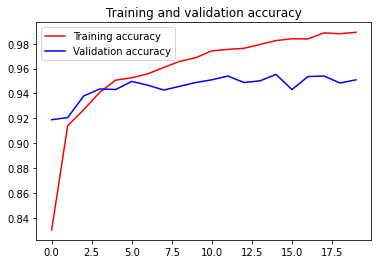

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

<Figure size 432x288 with 0 Axes>

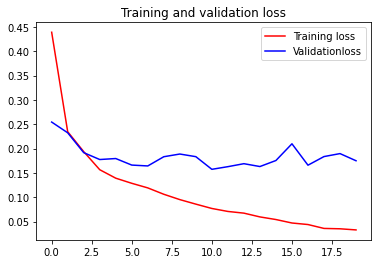

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


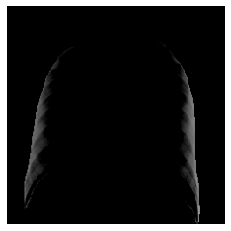

True label: Normal
Predicted label: Normal


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES= ['COVID19','NORMAL','PNEUMONIA','TUBERCOLOSIS']
def prepare(filepath):
    IMG_SIZE=224
    img_array=cv2.imread(filepath)
    img_array = img_array / 255.0
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)


prediction = model.predict(prepare('/content/drive/MyDrive/Final year project /Dataset/Segmented/Tubercolosis/Tubercolosis-1.png'))
prediction = np.argmax(prediction,-1)
print(prediction)
print(CATEGORIES[int(prediction[0])])

[3]
TUBERCOLOSIS


Testing the model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Final year project /Models/lung_mobilenet_segmented.h5')

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.2)

train_generator=train_datagen.flow_from_directory('/content/drive/MyDrive/Final year project /Dataset/Segmented',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Final year project /Dataset/Segmented', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data

Found 9353 images belonging to 4 classes.
Found 2337 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


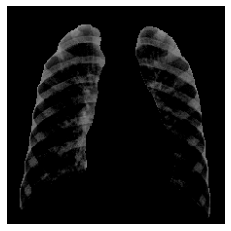

True label: Pneumonia
Predicted label: Pneumonia


In [ ]:
import matplotlib.pyplot as plt
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES= ['COVID19','NORMAL','PNEUMONIA','TUBERCOLOSIS']
def prepare(filepath):
    IMG_SIZE=224
    img_array=cv2.imread(filepath)
    img_array = img_array / 255.0
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)


prediction = model.predict(prepare('/content/drive/MyDrive/Final year project /Dataset/Segmented/Tubercolosis/Tuberculosis-10.png'))
prediction = np.argmax(prediction,-1)
print(prediction)
print(CATEGORIES[int(prediction[0])])

[3]
TUBERCOLOSIS
